IZVOR DATASETA: https://www.aminer.org/citation -> uzeta tada najnovija verzija v13

*potrebno popraviti i re-modelirati json datoteku u jsonline da se moze efikasnije citat - radi se o 17GB json tj 12 jsonl

#### svrha bilježnice: filtriranje podataka iz glavnog skupa podataka -dblpv13, odbacivanje "nevažećih" -> izrada podataka za graf

In [1]:
import jsonlines
import re
import gc
import pandas as pd
import jsonlines
import time
import seaborn as sn
import json
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
from igraph import *
from fastparquet import ParquetFile

In [2]:
cd ../datasets

[Errno 2] No such file or directory: '../datasets'
/home/dora/Desktop/recommender/helper_notebooks/zero_step_notebooks


In [ ]:
dataTable = []

with jsonlines.open("dblpv13.jsonl") as reader:
    for obj in reader: 
        columns=[]
        if obj.get('abstract') and len(obj.get('abstract'))>50:  #ima neispravnih abstracta, graf je dovoljno velik i bez tih loših primjeraka                       
            columns.append(obj.get('_id'))
            columns.append(obj.get('fos'))                           # fos:= field of study
            columns.append(obj.get('references'))
            columns.append(obj.get('title'))
            columns.append(obj.get('keywords'))
            columns.append(obj.get('url'))
            #columns.append(obj.get('n_citation'))
            columns.append(obj.get('abstract'))
            dataTable.append(columns)
   

In [4]:
#data = pd.DataFrame(dataTable)

In [5]:
data.columns = ['id','categories','references','title','keywords','url','abstract']

In [6]:
data.shape

(3851441, 7)

In [7]:
data.head()

,id,categories,references,title,keywords,url,abstract
0,53e99784b7602d9701f3e133,"[Agronomy, Moisture, Hydrology, Environmental ...",None,The relationship between canopy parameters and...,"[canopy parameters, canopy spectrum, different...",[http://dx.doi.org/10.1109/IGARSS.2011.6049503],Drought is the first place in all the natural ...
1,53e99784b7602d9701f3e15d,"[Delay calculation, Timing failure, Monte Carl...","[53e9a8a9b7602d97031f6bb9, 599c7b6b601a182cd27...",Timing yield estimation using statistical stat...,"[sequential circuits, statistical distribution...","[http://dx.doi.org/10.1109/ISCAS.2005.1465124,...",As process variations become a significant pro...
2,53e99784b7602d9701f3e161,None,None,360°,"[global high technology, daily short-distance ...",None,360° represents the concerns that are addresse...
3,53e99784b7602d9701f3e4f4,None,None,2BTextures,"[visual source material, minute sound, integra...","[http://dx.doi.org/10.1145/1596685.1596687, ht...","""2BTextures"", a two-movement audio/visual expe..."
4,53e99784b7602d9701f3eaf2,None,None,11MonkeysII,[],[http://dx.doi.org/10.1007/3-540-45324-5_74],Constructing a system that can cope with a dyn...


nasovi se čine smećoviti, filtriramo one od  <3 riječi, ima i naslova koji nisu string već lista..

In [8]:

bpd= []

for i,row in data.iterrows():
    if row.title:
        if isinstance(row.title, list):
            bpd.append(row)
        else:
            titleSplit= row.title.split()
            if len(titleSplit)<3:
                bpd.append(row)

            

In [9]:
len(bpd)

14144

In [10]:
#for b in bpd:
#    print(b.title)

..naslovi od 1 riječi su smeće u 99.999% slučajeva, od dvije većinski nisu. 

In [11]:
data.to_parquet("dblpv13.df.parquet", engine='pyarrow', compression='gzip')

In [12]:
#sveukupno 5_354_309 članaka - Arxiv je imao 1.9M 
#27.82% nema sazetak što čini 1_489_568 članaka  

dalje, radimo rječnik kategorija { id_clanka :kategorije}, trebati će nam za težine grafa

In [13]:
cat_dict=dict()

for row in data.itertuples():
    if row.categories:
        cat_dict[row.id]=row.categories


In [14]:
with open("cat_dict.json", 'w') as f: 
    json.dump(cat_dict, f)
    

radimo bridove - oblik tuple - [(v1,v2),(v3,v2),.......]

In [15]:
#with open("cat_dict.json", 'r') as f:
#    cat_dict = json.load(f)

In [52]:
vertices=set(data['id'])

In [34]:
edges=set()

for row in data.itertuples():
        iid=row.id
        if row.references:
            for r in row.references:
                if r in vertices:                
                    if iid > r : #poredak je bitan
                        edges.add((iid,r))
                        
                    else:
                        edges.add((r,iid))
                        

                
    

In [53]:
print("imamo",len(edges),"bridova","i",len(vertices),"vrhova - članaka")

imamo 35708851 bridova i 3851441 vrhova - članaka


težine ~ postotak podudaranja kategorija

In [36]:
weights=[]

for e in edges:
    e1=e[0]
    e2=e[1]
    w=0
    if e1 in cat_dict and e2 in cat_dict:
        a=cat_dict[e1]
        b=cat_dict[e2]
        inter=set(a).intersection(b)
        union=set(a).union(b)
        w=round((len(inter)/len(union))*100)
    weights.append(w)
  

In [37]:
#necemo dozvoliti tezine vrijednosti = 0 
zeros=[x for x in weights if x == 0] 

In [38]:
print(round((len(zeros)/len(edges))*100,2),"% bridova ima tezinu 0")

8.16 % bridova ima tezinu 0


In [39]:
np.average(weights),np.median(weights),np.std(weights),np.max(weights),np.min(weights)

(14.380820794261904, 12.0, 10.576122618921408, 100, 0)

bridovima težine 0 stavljamo težinu na 1

In [40]:
weights=[1 if x==0 else x for x in weights]

In [41]:
np.average(weights),np.median(weights),np.std(weights),np.max(weights),"--->",np.min(weights)

(14.462448735749016, 12.0, 10.468122127414041, 100, '--->', 1)

spremanje za easy access

In [50]:
edges=list(edges)
vertices=list(vertices)

In [48]:
with open('vertices.json', 'w') as f:
    json.dump(vertices, f)

In [44]:
with open('edges.json', 'w') as f:
    json.dump(edges, f)

In [45]:
with open('weights.json', 'w') as f:
    json.dump(weights, f)

In [49]:
len(weights)==len(edges)

True

vizualizacija težina

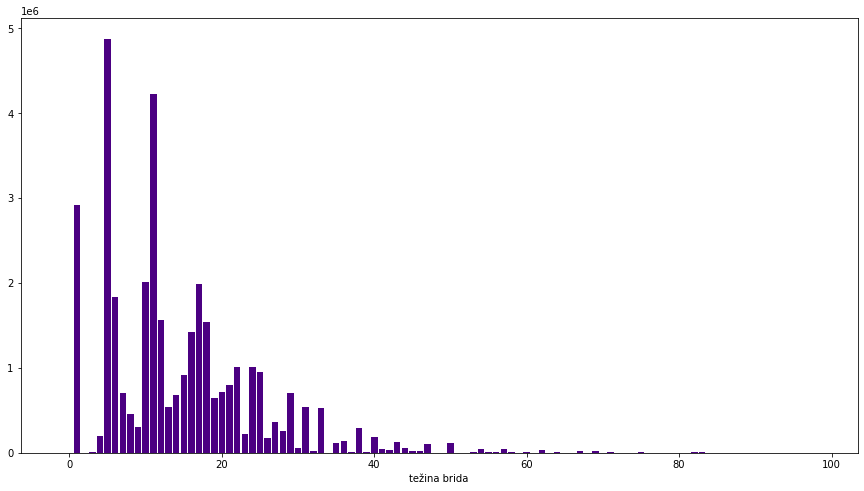

In [46]:
plt.figure(figsize=(15,8))
sn.distplot( weights,
            bins=np.arange(-1, 100),
            kde=False,
            hist_kws={"align" : "left",
                      "rwidth":0.85,
                      'alpha':1.0},
            color='indigo',
            axlabel="težina brida")
plt.show()


🍻